# LSA

© Anatolii Stehnii, 2018

Main goal of this assignment is to give you a basic understanding of how Latent Semantic Analysis is performed and how to interpret it results. In this work you will calculate word embeddings using LSA for arbitrary text and explore their properties.

Code from [Yuri Guts's Thrones2Vec](https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb) is used.

In [154]:
%env LC_ALL=en_US.UTF-8
%env LANG=en_US.UTF-8

import os
import re

import nltk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

env: LC_ALL=en_US.UTF-8
env: LANG=en_US.UTF-8


## Corpus preprocessing

First, download any text and save it in `./data/part1/corpus.txt`. I recommend you to use English text, but if you feel brave enough, you can setup a pipleline for any other language.

In [162]:
data_dir = "../data/part1"
corpus_file = os.path.join(data_dir, "corpus.txt")

with open(corpus_file, "r", ) as f:
    corpus = f.read()
print("Corpus is {0} characters long.".format(len(corpus)))

Corpus is 9748084 characters long.


We need to split our corpus on documents and split documents on terms. Use English tokenizers from NLTK or create your own function.

In [4]:
nltk.download("punkt")
nltk_english = nltk.data.load('tokenizers/punkt/english.pickle')
# use this or define your own document_tokenize
document_tokenize = lambda corpus: nltk_english.tokenize(corpus)

# use this or define your own word_tokenize
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [163]:
# split corpus on documents
documents_raw = document_tokenize(corpus)
# split documents on tokens
documents = list(map(word_tokenize, documents_raw))

Add your preprocessing if needed or use default:

In [164]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# default preprocessing – leave only alphabetical characters and stem tokens
# redefine this function, if you need another pipeline
def preprocess(word):
    clean = re.sub("[^a-zA-Z]","", word)
    clean_lower = clean.lower()
    return ps.stem(clean_lower)

In [165]:
# replace each word with preprocessed
documents = [[preprocess(word) for word in document] for document in documents]
# filter empty tokens
documents = [[word for word in document if word] for document in documents]

In [166]:
# Compare raw and preprocessed documents
print("Raw document: {}\n".format(documents_raw[5]))
print("Preprocessed document: {}\n".format(documents[5]))
print("-"*80)
token_count = sum([len(document) for document in documents])
print("The corpus contains {0:,} tokens in {1:,} documents".format(token_count, len(documents)))

Raw document: He was an old man, past fifty, and he had seen the lordlings come and go.

Preprocessed document: ['he', 'wa', 'an', 'old', 'man', 'past', 'fifti', 'and', 'he', 'had', 'seen', 'the', 'lordl', 'come', 'and', 'go']

--------------------------------------------------------------------------------
The corpus contains 1,807,559 tokens in 158,726 documents


Here we are filtering rare words from our documents. We clearly will not be able to analyze a word, if it occurs only a few times in a text. Define your threshold for a minimum word occurence in the text to filter rare words.

In [167]:
min_word_count = 3

words_count = {}
for d in documents:
    for w in d:
        if w in words_count:
            words_count[w] += 1
        else:
            words_count[w] = 1

rare_words = {w for w, count in words_count.items() if count < min_word_count}
print("The corpus vocabulary contains {0:,} unique words, {1:,} with less than {2:} occurences.".format(len(words_count), len(rare_words), min_word_count))

The corpus vocabulary contains 16,232 unique words, 6,080 with less than 3 occurences.


Define your own set of stop words or use default from NLTK:

In [168]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words = {'a', 'an', 'the'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [169]:
# remove stop words and rare words from documents
remove_words = rare_words | stop_words
documents = [[word for word in document if word not in remove_words] for document in documents]
print("Filtered document: {}" .format(documents[5]))
print("-"*80)

all_words = {word for document in documents for word in document}
vocabulary = {w:i for i, w in enumerate(sorted(all_words))}
print("A filtered vocabulary contains {} unique words".format(len(vocabulary)))

Filtered document: ['wa', 'old', 'man', 'past', 'fifti', 'seen', 'lordl', 'come', 'go']
--------------------------------------------------------------------------------
A filtered vocabulary contains 10030 unique words


## Term-document matrix

Here you need to transform your corpus into term-document matrix of any type you want (BoW, TF-IDF). Use a sparse matrix, if you have large amount of data. Don't forget to save your vocabulary so you can restore a row index for each word.

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=vocabulary)
documents_raw_join = [' '.join(words) for words in documents]
td_matrix = vectorizer.fit_transform(documents_raw_join)

## SVD

Perform SVD of term-document matrix and reduce it's dimensionality to n_dim components. 

In [171]:
n_dim = 200

In [172]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_dim)
u = svd.fit_transform(td_matrix.T)

In [173]:
print("Percent of variance explained: {0:.2f}".format(svd.explained_variance_ratio_.sum()))

Percent of variance explained: 0.33


In [174]:
word_ebeddings = u

## Explore result

Select a set of words you would like to explore.

In [175]:
# [w for w in vocabulary.keys() if w > 'stann']
# [d for d in documents if 'stanni' in d]

In [176]:
words = ['king', 'queen', 'robert', 'cersei', 'daeneri', 'stanni', 'man', 'woman']
indexes = [vocabulary[word] for word in words]

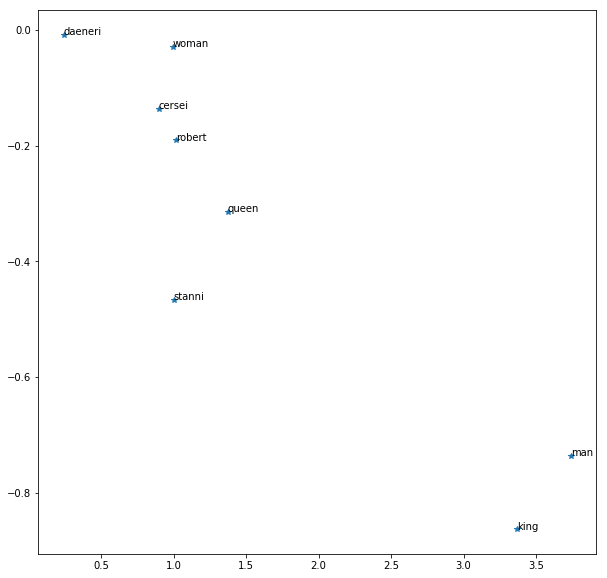

In [177]:
# plot first two components on a plane
plt.figure()
coordinates  = [word_ebeddings[i,0:2] for i in indexes]
xdata, ydata = zip(*coordinates)
plt.plot(xdata, ydata, '*')
for c, word in zip(coordinates, words):
    plt.text(c[0], c[1], word)
plt.show()

In [178]:
# measure if distances are meaningful
from scipy import spatial
import itertools

words = ['cersei', 'daeneri', 'man', 'woman', 'king', 'queen']

for w1, w2 in itertools.combinations(words, 2):
    v1 = word_ebeddings[vocabulary[w1]]
    v2 = word_ebeddings[vocabulary[w2]]
    print('Distance for words {} and {}: {}'.format(w1, w2, spatial.distance.euclidean(v1, v2)))

Distance for words cersei and daeneri: 13.780928026340282
Distance for words cersei and man: 24.00409799998542
Distance for words cersei and woman: 19.204887675174046
Distance for words cersei and king: 24.50210448129264
Distance for words cersei and queen: 20.910540165051245
Distance for words daeneri and man: 19.73472194625457
Distance for words daeneri and woman: 13.513696968498927
Distance for words daeneri and king: 20.504648447013825
Distance for words daeneri and queen: 15.939262609723846
Distance for words man and woman: 23.683317713506234
Distance for words man and king: 28.168588813570576
Distance for words man and queen: 25.42158288349171
Distance for words woman and king: 24.493222310856208
Distance for words woman and queen: 21.003426440549507
Distance for words king and queen: 25.778771733845925


In [179]:
# try to find meaning for individual components
component = 1
values = word_ebeddings[:,component].tolist()
words_values = list(sorted(zip(vocabulary.items(), values), key=lambda x: x[1]))
words_values[:20]

[(('hi', 4067), -11.976653525661005),
 (('said', 7275), -9.669906898994213),
 (('lord', 5038), -5.364032745567531),
 (('would', 9914), -3.098516357950785),
 (('hand', 3859), -2.1824572886153413),
 (('know', 4699), -2.0068878385897793),
 (('ser', 7509), -1.805687872733378),
 (('head', 3967), -1.3975196266670389),
 (('father', 2881), -1.3576708227525902),
 (('back', 476), -1.2518428037420863),
 (('eye', 2799), -1.2505470098139995),
 (('tyrion', 9152), -1.1589648607993257),
 (('jon', 4555), -1.0713501439804998),
 (('ha', 3774), -1.0311331364090077),
 (('want', 9567), -1.012886677931294),
 (('brother', 1088), -0.970279832081538),
 (('see', 7462), -0.9111804346352429),
 (('us', 9385), -0.8746542375433575),
 (('king', 4652), -0.8631520888276841),
 (('must', 5625), -0.8516066655499834)]

In [180]:
words_values[-20:]

[(('full', 3299), 0.15404019377163766),
 (('dream', 2410), 0.15659673363209017),
 (('cold', 1559), 0.15677531685464088),
 (('born', 943), 0.16922664013524188),
 (('realiz', 6832), 0.17184025727139252),
 (('tire', 8881), 0.17372756195157896),
 (('thing', 8772), 0.18413017496698733),
 (('hard', 3878), 0.21055268391244875),
 (('certain', 1314), 0.23516545756460813),
 (('still', 8291), 0.2485484186498868),
 (('time', 8866), 0.2530190487952263),
 (('afraid', 110), 0.2614552353618586),
 (('done', 2319), 0.2682603350342289),
 (('gone', 3533), 0.2947955293582146),
 (('knew', 4686), 0.34311978396096826),
 (('wrong', 9940), 0.3649460923540918),
 (('though', 8794), 0.3980783552817557),
 (('true', 9064), 0.4015589726731382),
 (('onli', 5957), 0.5530910494046911),
 (('wa', 9529), 23.106540512107728)]

## Save results
We will need preprocessed dataset and word embeddings in the next assignment, so let's save it.

In [181]:
# Store vocabulary as word per line. Indexes can be easily restored from order, therore they are ommited
with open(os.path.join(data_dir, 'vocabulary.txt'), "w") as f:
    vocab_str = '\n'.join(vocabulary.keys())
    f.write(vocab_str)

In [185]:
# Store corpus, document per line, each token replaced with index
with open(os.path.join(data_dir, 'corpus_preprocessed.txt'), "w") as f:
    corpus_str = '\n'.join([' '.join([str(vocabulary[token]) for token in document]) for document in documents])
    f.write(corpus_str)

In [186]:
# Store LSA embeddings
np.save(os.path.join(data_dir, 'lsa_embeddings.npy'), word_ebeddings)